---
Topic: `Sentiment Analysis for Cyberbullying Detection on Twitter - Sentiment Analyiser`

Date: `2023/05/04`

Programming Language: `python`

Main: `Natural Language Processing (NLP)`

---

### Introduction

Sentiment analyis (SA) is a supervised or unsupervised machine learning task for classifying the popularity of a given text. Given a text and labels a model can be trained to classify the category the text belongs to for example it can classify wether a given text fall under `positive`, `negative` or `neutral`. SA can be either a `multi-class` classification or a `binary` classification task.

### Abstract
Sentiment analyisis is a very useful study in modern technology. SA goal is to study human opinion over written text of natural languages. Natural languages are languages that are spoken by people, unlike programming language natural languages comes natural for example Shona, English, Ndebele etc. SA can analyise human emotions, attitude, opinion, sentiments over a written language. This study is very useful in systems like chatbots and virtual assistance in making decisions when interacting with human beings.


_In this notebook I'm going to implement and train a model from scratch using modern python libraries such as `pytorch` by `facebook` that does a general sentiment analyisis classification task based on `3` class labels (`positive`, `negative`, `neutral`). Each code cell that we are going to execute will be explained by the use of `Markdown` that's why I choose `.ipyb` or `IPython` notebook to write code for model training._

### Keywords
Natural Language Processing (NLP),  Sentiment Analysis, Long Short Term Memory (LSTM), Bi-Directional.


### Cloud File System

This notebook is an instance of a cloud notebook (Google Colab) notebook where we can write code in the browser without installing any packages or any programming language. Alternatively one can use `Jupyter Notebooks` to perform this task but for speed we may consider using something like `Google Colab` because it offers free `Graphic Processing Units (GPU)` and `Tensor Processing Unit (TPU)`. These devices or runtime environments allows our code to execute fast because they are good when it comes to mathematical computations as compared to `Central Processing Units (CPU)`

When you are using `Google Colab` you might as well think of accessing your file system. Fortunate enough google made it easy for developers because there's an `API` that allows us to directly link our `Google Drive` cloud storage with `Google Colab`. Also most of the datascientists use the API like `Kaggle` to access the dataset without bothering uploading the dataset in the google drive storage. The following shows how our file system looks like in the google drive.

```
📁 drive
  📁 My Drive
    📁 Cyber Bullying on Twitter
       - keys.json
       - [category].csv
       - clean_tweets.csv

* category can be either one of the categories that we have tageted when fetching cyberbullying data between [education, sports and politics]    
```
> Note that the `clean_tweets.csv` contains our dataset with cleaned paired to their labels and was obtained in the prevoius notebook. 


### Phyiscal Devices
As i mentioned before that we are going to make use of free `GPU` we need to make sure that we change the runtime type by clicking on the `Runtime` menu > `Change Runtime Type` > `GPU`

### Mounting the Drive

In order to use the google drive in google colab we have to mount it and give google colab access to our google drive storage. We can mount the drive by running the following code cell.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Path to our files
In the following code cell we are going to define the paths to our files. We are going to make use of the `os` built in python module to manage our paths.

In [2]:
import os
base_path = '/content/drive/My Drive/Cyber Bullying on Twitter'

assert os.path.exists(base_path), f"Path '{base_path}' does not exists."

# path to our csv file
data_path = os.path.join(base_path, 'clean_tweets.csv')
assert os.path.exists(data_path), f"Path '{data_path}' does not exists."


### Installing `helperfns`

In the following code cell we are going to install the package called `helperfns` which is the package that i've create that provides us with some usefull helper functions for machine learning.

In [3]:
pip install helperfns -q

  Preparing metadata (setup.py) ... done


### Imports

Ofcause we are going to import packages that we are going to use in this notebook. In the following codecell we are going to import the basic modules that we are going to use in this notebook. 

The major modules that we are going to use that are not built-ins in python are as follows.

1. `torchtext` - for working with `tensors` alternatively we can use `tensorflow` by `google` but i chose `pytorch` because why not.
2. `matplotlib.pyplot` - for visualizing interms of graphs
3. `helperfns` - provides us with some helper functions that we are going to use along the way.
4. `pandas` - for working with dataframes
5. `numpy` - numerical python, this package allows us to simply work with arrays very easily in python. Good news is that tensorflow keras can also work with these arrays directly instead of tensorflow tensors.
6. `seaborn` - this package is used to do some colorful chats visualizations
8. `sklearn` - offers some classes and functions that helps us to easily work with `2d` or `1d` data for example we can use the `tran_test_split` method from `sklearn` model selection to split examples into subsets.
9. `torchtext` - consists of data processing utilities and popular datasets for natural language in pytorch.

> Note that other packages that i did not mention here will be explained as we go, that's the reason i chose interactive notebook over writting this code in an code editor.

In [4]:
import time
import json
import torch
import os
import re
import random
import torchtext
from matplotlib import pyplot as plt
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab
import seaborn as sns

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from helperfns.text import de_contract

import torch.nn.functional as F
import numpy as np
import pandas as pd
import wordcloud as wc

from google.colab import drive, files

torchtext.__version__, torch.__version__

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


('0.15.1+cpu', '2.0.0+cu118')

### Seed

In the following code cell we are going to set a `seed` for random reproducivity. In datascience we share code, so inoder to get the same output when running the same code at different times we need to set the seed to all random actions that we are going to make. In the following code cell i will set the seed to `42` for random reproducivity. Note that this seed can be any integer number you want. Changing this seed may result in changing results at the end.

In [5]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Physical Device & GPU acceration

As i stated earlier on that we need to have access to physical devices such as `GPU` or `TPU` so that executing mathematical computations becomes time efficient. We are going to make use of a `GPU`. So we want a way of creating a device using `torch`


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data
Our `clean_tweets.csv` file contains rows of examples where we will find text paired to their sentiment labels. In this section i will expain line by line data processing pipeline starting from loading a `.csv` file using pandas and visualizing and checking examples. Note that our dataset contains three labels which will be programmatically shown in code cells that will come after we load our data in a dataframe using `pandas`.


### Creating a dataframe
In the following code cell we are going to load the dataset using the `pandas` module which we have imported with alias `pd` in a dataframe. We are going to use the `read_csv` function from pandas to read the `coma-seperated-values` data from our file as follows:

In [7]:
dataframe = pd.read_csv(data_path)

### Checking the first `5` rows of the dataframe

In pandas the method `head(n)` on a dataframe instance allows us to check the first `n` rows and the method `tail(n)` allows us to check the last `n` rows of the data in the dataframe. We want to check the first `10` rows so that we will be familiar with how our `data` looks like before doing any preprocessing on features and labels.

In [8]:
dataframe.head(5)

,text,label
0,need quality education,neutral
1,na still ipob is trying to bring nigerians fro...,negative
2,disney packup your toys amp move to a liberal ...,negative
3,the world is very beautiful but some people is...,positive
4,desantis' cartoon villainy gives disney is law...,positive


### Our dataframe

Based on the dataframe that we have we are only intrested in two columns which are:

1. `labels` - values are `positive`, `negative` and `nuetral`
2. `text` - this is the actual tweet text.

### Counting examples

In the following code cell we are going to visualize how many unique `sentiments` (which is our target value ) values are there in our dataframe. We are going to use the `seaborn` module taht was imported earlier with an alias `sns`. In this module we will found a method called `countplot` which will plot all the total count aganist the `target` name as follows:


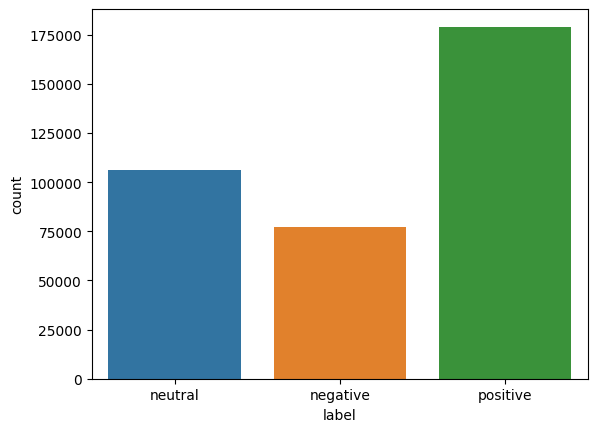

In [9]:
sns.countplot(x="label", data=dataframe)
plt.show()

### Observesion

From the above we can be able to see that there are more positive sentiments in this dataset. This brings us to a conclusion that the dataset has unbalanced labels and there's a high posibility that our model will overfit for positive sentiments. But we are going to make use of Natural Language Processing (NLP) techniquies to avoid this rather than balancing the labels.


### Null columns.

Our dataset is a dataset that was created using scrapping with the twitter API. There's high posibility that we have `null` values or `na` values on other columns. The first rule that we should do when working with pandas dataframes to to drop `na` values. In the following code cell we are going to check if we have `na` valued in our dataframe.

In [10]:
## Checking if there are 'na' valued in the dataframe
dataframe.isna().any()

text      True
label    False
dtype: bool

> We can see and conclude that there are no `na` values in our dataset.

Next we are going to check if there are `null` values in our dataframe.

In [11]:
dataframe.isnull().any()

text      True
label    False
dtype: bool

> As we can see that we have a column with null values in our dataset. If it happened that you have null values in your dataset especially on the collumns that you are working with you will need to drop them for example using the code that says:

```py
dataframe = dataframe.dropna()
```
> note that a pandas method on a datafram `dropna` does not perform action in place so that's why we are re-assigning the dataframe.

This is the first thing datascientist do before working with dataframes in pandas.


In [12]:
dataframe = dataframe.dropna()

### Features and labels

In this dataset we are interested in predicting the sentiment weather it's `positive` , `neutral` or `negative` based on the text. So based on the data that we have we are interested in two columns:

1. label
- Target values`negative`, `nuetral` or `positive`.

2. text
- This is the text in context with cyber bulling that need to be sentimented `positive`, `nuetral` or `negative`

We are going to extract features(text) and labels(targets) into numpy array and do some preprocessing on them. The preprocessing steps will be expained line by line.

### Labels

Our target values are already numeric so we don't need to do anything as we preprocess them in the previous notebook.

In [13]:
targets = dataframe.label.values

Checking the first and last `3` target values

In [14]:
targets[:3], targets[-3:]

(array(['neutral', 'negative', 'negative'], dtype=object),
 array(['positive', 'positive', 'positive'], dtype=object))

### Features (text)

In the previous notebook we cleaned our text, so theres nothing that we are going for text cleaning on our features.


In [15]:
texts = dataframe.text.values

In [16]:
texts[:3]

array(['need quality education',
       'na still ipob is trying to bring nigerians from sudan with his aeroplane but and up papa dey twitter de vomit rubbish look at how nigerian politics has turned you to children of hate and bigots',
       'disney packup your toys amp move to a liberal blue state dont take shit from republicans desantis aligned board votes to sue disney desantis aligned board votes to sue disney'],
      dtype=object)

### Balancing Dataset

In the following code cell we are going to try to balance our class labels, as we saw in the visualization that our `positive` sentiments are more than others we are going to try to balance them with at least the `negative` sentiments. The reason i didn't want to balance all the `3` target values is that, i'm afraid we will trim more examples and the dataset will be very small.


We will start by counting how may negative labels do we have in the following code cell.

In [17]:
negative_label = 'negative'
negative_count = list(targets).count(negative_label)
negative_count

77085

Based on this negative count value we are going to create a new variable called dataset that will store a newly created dataset with positive and negative labels balanced.

In [18]:
dataset = list()
positive_count = 0
neutral_count = 0
for feature, label in zip(texts, targets):
  if label == 'negative':
    # negative add
    dataset.append([feature, label])
  elif label == 'neutral':
     # balance the neutral and negative labels (neutral)
    if negative_count == neutral_count:
      continue
    else:
      neutral_count += 1
      dataset.append([feature, label])
  elif label == 'positive':
    # balance the positive and negative labels (positive)
    if negative_count == positive_count:
      continue
    else:
      positive_count += 1
      dataset.append([feature, label])

### Extracting balanced Features and labels.

Balanced features and labels will be extracted in the following code cell. But before we do that we can shuffle them, just to make sure that labels shuffled and nice.

In [19]:
random.shuffle(dataset)

In [20]:
features = list()
labels = list()

for (feature, label) in dataset:
  features.append(feature)
  labels.append(label)

# check just to make sure features and labels has the same length
assert len(features) == len(labels), f"Features and labels must have the same length recieved {len(features)} and {len(labels)}."

### Checking the most common words

In the following code cell we are going to use `wordcloud` package that we have imported with an alias `wc` and check the most appearing word in our dataset. Note that we can specify the `max_words` arg and the maximum number of words that you want your wordcloud to have. But in this one we are not going to have a look at that.

In [21]:
full_text = " ".join(features)

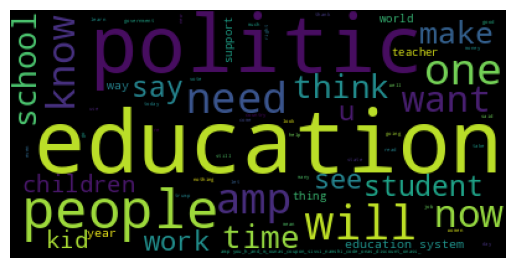

In [22]:
wordcloud = wc.WordCloud().generate(full_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As we can see that the most appearing word in our corpus is `"education"` which is the parameter of interest of our study.

### Generating sets.
In machine learning (supervised machine learning) when creating models we need to have three sets of data which are:

1. training
2. validation
3. testing


1. `train` - The train set is used to train the model so that it will learn the mathematical mapping or relationship between features and labels. These features and labels must be at some point be converted to numerical values.

2. `validation` - The validation set is the same as the test set but it's just that the validation set is used during model training and it is used to measure how accurate our model is becoming interms of metrics such as loss, accuracy, etc. Theoretically the validation set must come from a fraction of the train dataset but with test set transformation. The reason is being that the validation set must represent the test dataset as much as posible.

3. `testing` - The testing set is the one that will completely measure how our model has learn the mappings between labels and features. In this set we wouldn't want our model to know about it inorder for us to have unbiased metric representation. I will explain later on more about this during model evaluation and model inference.

> Note that in this notebook our `validation` data will come from the `train` examples.

We are going to use the `train_test_split` method from `sklearn.model_selection` to split our dataset into different subsets. Note that we are going to set the `random_state` to our `SEED` for reproducivity and this also allows us to shuffle examples in our dataset. We don't want a case where we will have about `~10` negative reviews that follows each other they should be mixed so that our model won't overfit. We will explain more about the overfit part later on.

In [23]:
train_text, test_text, train_labels, test_labels = train_test_split(
    features, labels, random_state=SEED, test_size= .2
)

#  the validation set should come from the train examples
train_text, val_text, train_labels, val_labels  = train_test_split(
    train_text, train_labels, random_state=SEED, test_size= .2
)

### Saving splitted Examples
Now that we have extracted the examples and labels for each of the following set:

1. `train`
2. `testing`
3. `validation`

We can create dataframes for each set and save `.csv` files for each set in the following way.

1. `train.csv` - contains training data
2. `testing.csv` - contains testing data
3. `validation.csv` - contains validation data

In [24]:
train_df = pd.DataFrame(zip(train_text, train_labels), columns=["text", "label" ])
test_df = pd.DataFrame(zip(test_text, test_labels), columns=["text", "label" ])
val_df = pd.DataFrame(zip(val_text, val_labels), columns=["text", "label" ])

Checking our dataframes.

1. train dataframe

In [25]:
train_df.head(5)

,text,label
0,he is a stain on french politics,neutral
1,i signed up for the education empowerment on may,neutral
2,_robert _lib _mr _pilled i saw you th grade ed...,neutral
3,this nc high school will close half of its res...,negative
4,_views some parties have turned politics into ...,neutral


2. test dataframe

In [26]:
test_df.head(5)

,text,label
0,and clearly anyone with a real education knows...,positive
1,schumer 'hopeful' ailing sen feinstein returns...,negative
2,it is rotten from top to bottom the only cuts ...,neutral
3,orientation implementation of physical educati...,neutral
4,free analysis live around improve politics nat...,positive


3. validatation dataframe

In [27]:
val_df.head(5)

,text,label
0,first republic bank crisis plunges biden team ...,negative
1,green party co leader marama davidson can not ...,negative
2,keynote speakers confirmed at you will hear fr...,positive
3,_parn _lucre you are in wa why such a vested i...,neutral
4,does anyone care what the chamber of commerce ...,positive


Now that we have text matched to labels, we can go ahead and save the `csv` files for these `3` different sets of data

In [28]:
train_df.to_csv(os.path.join(base_path, "train.csv"),  index = False, header = True)
test_df.to_csv(os.path.join(base_path, "test.csv"),  index = False, header = True)
val_df.to_csv(os.path.join(base_path, "val.csv"),  index = False, header = True)
print("Done")

Done


### Counting and visualizing examples

In this section we are going to do data visualisation in terms of plots and tables. We are going to count examples for each subset and then we will the visualize by the use of a table. Another thing that we can do is to count and visualize how the `labels` are distributed in terms of number in each set. So we will count how many examples are in each set and visualize them using a bar graph.

 We can use a helper function from `helperfns` package that is called `tabulate_data` to do this.

In [29]:
columns = [
    "Set", "Total", "Neutral", "Negative", "Positive"
]
examples = [
   ("training", len(train_labels), list(train_labels).count('neutral'), list(train_labels).count('negative'), list(train_labels).count('positive')),
    ("testing", len(test_labels), list(test_labels).count('neutral'), list(test_labels).count('negative'), list(test_labels).count('positive')),
    ("validation", len(val_labels), list(val_labels).count('neutral'), list(val_labels).count('negative'), list(val_labels).count('positive')),
   ("total", len(labels), list(labels).count('neutral'), list(labels).count('negative'), list(labels).count('positive')),
]
tabulate_data(columns, examples, "Exmples")

+------------+--------+---------+----------+----------+
| Set        |  Total | Neutral | Negative | Positive |
+------------+--------+---------+----------+----------+
| training   | 148003 |   49380 |    49365 |    49258 |
| testing    |  46251 |   15297 |    15557 |    15397 |
| validation |  37001 |   12408 |    12163 |    12430 |
| total      | 231255 |   77085 |    77085 |    77085 |
+------------+--------+---------+----------+----------+


### Preparing Features(texts) and Labels(labels) for model training.

In deep learning/machine learning model does not take in raw data such as text. We need to convert text to a sequence of integer representation and have a word to index lookup for a word to an integer also known as a `vocabulary`. First let's get some features and labels from our different sets.


In [30]:
# train
train_texts = train_df.text.values
train_labels = train_df.label.values

# test
test_texts = test_df.text.values
test_labels = test_df.label.values

# val
val_texts = val_df.text.values
val_labels = val_df.label.values

### Labels preprocessing

Our labels for now are just `textual` (`positive`, `negative` or `neutral`). We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation.

As you have noticed we have `3` labels which are sentiments that we need to predict given a sequence of words or a single tweet.

The `label_pipeline` function will them takes in the label and then returns us an integer representation of that label.



In [31]:
sentiments = train_df.label.unique()
sentiments

array(['neutral', 'negative', 'positive'], dtype=object)

In [32]:
labels_dict = {k: v for v, k in enumerate([d.lower() for d in sentiments])}
label_pipeline = lambda x: labels_dict[x]

### Feature Extraction

In deep learning, feature extraction is the process of transforming raw data into numerical features that can be processed while preserving the information in the original data set. In this section we are going to preprocess our text(features) so that we will get the numerical representation of our text. 

There are a lot of ways we can do to convert these sentences in sequence of numbers one of the common way of doing which is older is using something called `"The Bag Of Words"` which has some limmitations. In this case we are not going to use it. We are going to take advantage of our `torchtext` library to create our `vocabulary`


### What is a vocabulary?

A vocabulary is esentially a `word` to `index` mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model `training` and also can be used as reference during model `inference`. Our vocabulary will be created based on the sentences that are in the train dataset. 


### Text Preprocessing
In our text processing pipeline we need to do the following steps:

1. tokenize sentences
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from `spacy` language model. You can read more about other tokenizers that you can use at [pytorch.org](https://pytorch.org/text/stable/data_utils.html).
2. vocabulary
We neet to create a vocabulary.


### Tokenizer

In the following code cell we are going to get a tokenier object that will convert a sentence into a sequence of word using the `spacy-en` language model. The reason we are using the english langauge model it's because our intents are in english.

In [33]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("cyber bullying is bad.")

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


['cyber', 'bullying', 'is', 'bad', '.']

### Creating a Vocabulary

I call this one the brain or memory of the model in NLP. A vocabulary is an index to word lookup. It is nothing but a python ordered dictionary with words as `keys` and `indices` as values. A vocabulary can look as follows:

```json
{"-pad-": 0, "-unk-": 1, "the": 2, "is": 3, .....}
```

In the following code cell we are going to create a vocabulary object from `torchtext`. So we are going to use the `Counter` module from collections to generate these counts from our train features.

We are going to specify the `min_freq` to `2` meaning that the words that does not appear at least `2`  does not have an impact in our corpus times and will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [34]:
counter = Counter()
for line in train_texts:
  counter.update(tokenizer(line))
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=2, specials=('-unk-', '-pad-', '-sos-', '-eos-'))

### STOI - String To Integer

This will be a dictionary that contains a `string` to `integer` mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [35]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (`stoi`) will be converted to an unkown `-unk-` token (`0`).

In [36]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['-unk-']
    values.append(v)
  return values


Let's create a function that will be able to converts tokens of integers to tokens of `string`. We aregoing to name this function `tokens_to_sequence`. But first we need to invernt the `stoi` to an `itos` dictionary which is a dictionary that contains `integers` and `keys` and `string` as `values`. 

In [37]:
itos = {v: k for k, v in stoi.items()}
def tokens_to_sequence(sequence: list[int]) -> list[str]:
  return [itos[i] for i in sequence]
tokens_to_sequence([1, 2, 3, 6])

['-pad-', '-sos-', '-eos-', 'a']

Now that we have our vocabularies for labels `labels_dict` and features `stoi` we can then save thes files as they will be used suring model inference. We are going to save these files as `.json` files.

In [38]:
with open(os.path.join(base_path, "vocab.json"), 'w') as f:
  f.write(json.dumps(stoi, indent=2))

with open(os.path.join(base_path, "labels_dict.json"), 'w') as f:
  f.write(json.dumps(labels_dict, indent=2))

print("Saved!!")

Saved!!


Now our features and labels are ready for model training we are now introducing a new important asspect in natural langauage processing which is nothing but.

### Word Embeddings
Embeddings transform a `one-hot` encoded vector (a vector that is 0 in elements except one, which is 1) into a much smaller dimension vector of real numbers. The `one-hot` encoded vector is also known as a `sparse vector`, whilst the real valued vector is known as a `dense vector`.

The key concept in these word embeddings is that words that appear in similar contexts appear nearby in the vector space, i.e. the **Euclidean distance** between these two word vectors is small. By context here, we mean the surrounding words. For example in the sentences `"I purchased some items at the shop"` and `"I purchased some items at the store"` the words `'shop'` and `'store'` appear in the same context and thus should be close together in vector space, this means that the **Euclidean distance** between the word `shop` and `store` is very small.

> If you want to read more about word embeddings you can visit this notebook [CrispenGari/pytorch-python](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/02_Sentiment_Analyisis_Series/10_A_closer_look_on_Word_Embeddings.ipynb) for better understanding in theory.

If you are an expert in NLP you may have heard that `'woman'` added to the vector of `'king'` minus the vector of `'man'` give us `'queen'`. 

### Why does this work?

If we think about it, the vector calculated from `'king'` minus `'man'` gives us a `"royalty vector"`. This is the vector associated with traveling from a man to his royal counterpart, a king. If we add this `"royality vector"` to `'woman'`, this should travel to her royal equivalent, which is a `queen`! 

For better understanding of this consept visit the notebook that I've referenced.

### Glove Word Vectors

We are going to load the `Glove.6B.100d.txt` file as our pretrained word vectors. As the name suggested these vectors was trained with `~6B` words and has `100` dimension vectors. `GloVe` vectors are available in `50`, `100`, `200` and `300` dimensions. There is also a `42B` and `840B` glove vectors, however they are only available at `300` dimensions.

### Why are we even loading Word vectors in our model?

We want to create a general purpose sentment analyizer model that will be able to classify sentiments accurately. These pretrained word embeddings gives us a super power so that our model can easily learn the mappings between labels and features within a short period of time with only few epochs.


In the following code cell we are going to load the `embedding` vectors from a txt file into an embedding dictionary.


In the following code cell we are going to download the predtrained word vectors. We are going to use the `GloVe.6B.100d`. These are pretrained vectors that were trained with about `~6B` words and have a vector representation of a word in `100` dimension for each word.

In [39]:
EMBEDDING_DIM = 100
glove_vectors = vocab.GloVe('6B', dim=EMBEDDING_DIM)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.33MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 22723.57it/s]


### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [40]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word `"bad"`.

In [41]:
EMBEDDING_MATRIX[stoi['bad']]

tensor([ 0.3946, -0.2472,  1.0319, -0.6144, -1.2376,  0.0518, -0.5511, -0.3101,
        -0.0257, -0.2471,  0.2584,  0.3490,  0.4618,  0.4424,  0.3540,  0.2126,
        -0.2631, -0.1713,  0.4401,  1.1284,  0.3726,  0.4197, -0.2534, -0.0519,
        -0.3492,  0.1530, -0.6844, -0.1951, -0.0186,  0.0842,  0.1457,  0.3869,
         0.0235, -0.3786, -0.6508,  0.0104, -0.5009, -0.0874,  0.0986, -0.2191,
        -0.0724, -0.1025, -0.3148, -0.3070, -0.3046, -0.1433,  0.1031, -0.0405,
        -0.0959, -1.1920, -0.0634,  0.0341, -0.0577,  0.5658,  0.0825, -2.4617,
         0.4803,  0.7281,  1.2841,  0.1067, -0.0451,  1.0117, -0.9793,  0.0228,
         0.4688, -0.0269,  0.8002, -0.2310,  0.0867, -0.7434, -0.3874, -0.1924,
        -0.1329,  0.5235,  0.3566,  0.2106, -0.1867,  0.4156, -0.5087,  0.4764,
         0.7859,  0.2801, -0.7456, -0.0156, -1.8451, -0.2843, -0.8172, -0.4325,
        -0.6003, -0.4005, -0.2661, -0.0586, -0.2051,  0.1621, -0.2530,  0.4816,
        -0.1591,  0.0065,  0.1379, -0.06

### Creating Dataset for Training
In the following code cell we are going to create a a custom dataset class called `CBTSADataset` which will inherit from `data.Dataset`. This dataset will takes in the labels and the text of a set.

In [42]:
class CBTSADataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(CBTSADataset, self).__init__()
    self.labels = labels
    self.text = text
      
  def __getitem__(self, index):
    return self.labels[index], self.text[index]
  
  def __len__(self):
    return len(self.labels)

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function actually takes in a batch and does the preprocessing of the `text` and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

1. `tokenize_batch` function:

* this function takes in a `batch` in each set and convert the features and labels to integer representation. It goes ahead and `pad` and `truncate` the sequence to the same length and returns labels and features.

### Pading and truncating of tweets.

These tweets contains different lengths interms of words. In theory and practically these sequence must be of the same `size` or `length`. The reason why these sequences are of different lengths it's because the sentences are of different lengths to begin with. So to make these sentences or text have the same lengths, all the longer sentences must be `truncated` and all the shorter sentences must be `padded` with the pad token (`1`). So we need to define the `max_length` of our sentence so that the padding and truncating takes place to this common `length`. 


So all this will happen in the `tokenize_batch` function.




In [43]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  return torch.LongTensor(labels_list), torch.cat(text_list, dim=0)

> Note that in pytorch our labels should be specifically of type `LongTensor` when it is a multi-lable classification.

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `CBTSADataset` class.

In [44]:
train_dataset = CBTSADataset(train_labels, train_texts)
test_dataset = CBTSADataset(test_labels, test_texts)
val_dataset = CBTSADataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the `validation` and `testing` dataset we are going to set the `shuffle` to `False` because there's no need fo us to shuffle these examples.

In [45]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [46]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [47]:
lbl

tensor([1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1,
        2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1,
        1, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 2, 1, 2,
        2, 0, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        2, 0, 1, 1, 2, 2, 0, 1])

The first sentence in the batch.

In [48]:
txt[0]

tensor([ 4397,    50,   423,    15,  4324,    39,    15,  1856,    45,   736,
         6621,  7953,   120, 14266,  1469,    62,  7124,     5,    74,  6051,
          194,    57,    16,   316,  4397,   127, 15049,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       dtype=torch.int32)

### Model Creation
Now that we have our loaders we can now create a model. The model that we are going to create is called `CBTSAModel`. As mentioned we are going to use `BiDirectional Long Short Term Memory (BiLSTM)` to build this model.

### Model

Our model will be a very simple classification model. There are three ways of building a model in tensorflow keras. These ways are:

In this notebook we are going to create a `Bi-Directional RNN` model for text classification. I'm not going to explain the mathematical theory that much in this presentation but you can read more about what the input shape does `RNN` (Recurrent Nueral Networks) accepts [CrispenGari/pytorch-python](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/02_Sentiment_Analyisis_Series/01_Simple_Sentiment_Analysis.ipynb).

### Why Recurrent Nueral Networks (RNN)
These are nothing but layers which are commonly used and seems to be good in processing `sequential` data. These layers are used mostly in `audio` processing, `time-series` or `text-sequences`. These layers are a good fit to our case because we are working with sequential data.

We are going to make use of an `RNN` type called `Long Short Term Memory (LSTM)`


### Why is an LSTM better than a standard RNN? 

Standard `RNNs` suffer from the vanishing gradient problem. `LSTMs` overcome this by having an extra recurrent state called a `cell`, which can be thought of as the "memory" of the LSTM and the use use multiple gates which control the flow of information into and out of the memory. If you want to know the mathematics or clear explanation about these layers you can read them here [CrispenGari/pytorch-python](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/02_Sentiment_Analyisis_Series/02_Updated_Sentiment_Analysis.ipynb).

### Bidirectional `LSTM`.

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). In our model we are not going to have a  `Gated Reccurrent Unit (GRU)` which is another type of RNN.


### Regularization

Without going into overfitting into too much detail, the more parameters you have in in your model, the higher the probability that your model will overfit (memorize the training data, causing a low training error but high validation/testing error, i.e. poor generalization to new, unseen examples). To combat this, we use regularization. More specifically, we use a method of regularization called dropout. 

`Dropout` works by randomly dropping out (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.


Our model clas will be called `CBTSAModel` and it is implemented in the following code cell.



In [49]:
class CBTSAModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers
               , bidirectional, dropout, pad_idx):
    super(CBTSAModel, self).__init__()

    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx),
        nn.Dropout(dropout)
    )
    self.lstm = nn.Sequential(
        nn.LSTM(
          embedding_size, 
          hidden_size=hidden_size, 
          bidirectional=bidirectional, 
          num_layers=num_layers,
          dropout=dropout
        )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=225),
        nn.Dropout(dropout),
        nn.Linear(225, out_features=64),
        nn.Dropout(dropout),
        nn.Linear(64, out_features=output_size),
        nn.Dropout(dropout)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    # set batch_first=true since input shape has batch_size first and text_lengths to the device.
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
    packed_output, (h_0, c_0) = self.lstm(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    output = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1)
    return self.out(output)
     

### Model Instance
In the following code cell we are going to create a model instance.

In [50]:
INPUT_DIM = len(stoi) 
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.45
PAD_IDX = stoi['-pad-'] 
cbtsa_model = CBTSAModel(
              INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX
).to(device)
cbtsa_model

CBTSAModel(
  (embedding): Sequential(
    (0): Embedding(40571, 100, padding_idx=1)
    (1): Dropout(p=0.45, inplace=False)
  )
  (lstm): Sequential(
    (0): LSTM(100, 256, num_layers=2, dropout=0.45, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.45, inplace=False)
    (2): Linear(in_features=128, out_features=225, bias=True)
    (3): Dropout(p=0.45, inplace=False)
    (4): Linear(in_features=225, out_features=64, bias=True)
    (5): Dropout(p=0.45, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
    (7): Dropout(p=0.45, inplace=False)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters. We are just going to have a look at total parameters and total trainable parameter. We are going to use the helper function that I've created called `models_params` from `helperfns.model`

In [51]:
models.model_params(cbtsa_model)

TOTAL MODEL PARAMETERS: 	6,476,592
TOTAL TRAINABLE PARAMETERS: 	6,476,592


### Loading Embedding Vectors

In the following code cell we are going to load the pretained custom vectors in our embedding layer. We are going to load the embedding vectors tha suits our data using the `cbtsa_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)` as follows:

In [52]:
cbtsa_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.8352, -0.6938,  0.0356,  ...,  0.5222, -0.5881,  0.2428],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### Optimizer and Criterion
In the following code cell we are going to define the `optimizer` and `criterion`. For the `optimizer` we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [53]:
optimizer = torch.optim.Adam(cbtsa_model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the `catecorical` accuracy between the `predicted` labels and real `labels`.

In [54]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [55]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop

In the following code cell we are going to run the training loop. We are going to save the model when our loss decreased from the previous loss stored. And we are also going to keep in track of our training history so that we can visualize it later on.

In [56]:
N_EPOCHS = 20
MODEL_NAME = 'cbtsa_model.pt'

# we need a way of keeping tracking the matrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

training_start = time.time()
best_valid_loss = float('inf')
last_saved_epoch = 0
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(cbtsa_model, train_loader, optimizer, criterion)
  val_loss, val_acc = evaluate(cbtsa_model, val_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if val_loss < best_valid_loss else 'not saving...'}"
  if val_loss < best_valid_loss:
      best_valid_loss = val_loss
      last_saved_epoch = epoch + 1
      torch.save(cbtsa_model.state_dict(), MODEL_NAME)
  end = time.time()

  # keep in track of all the metrics during training
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  data = [
       ["Training", f'{train_loss:.3f}', f'{train_acc * 100:.3f}%',  f"{hms_string(end - start)}" ],
       ["Validation", f'{val_loss:.3f}', f'{val_acc * 100:.3f}%', "" ],       
   ]
  columns = ["CATEGORY", "LOSS", "ACCURACY",  "ETA"]
  print(title)
  tabulate_data(columns, data, title)

training_end= time.time()

EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.737 |  64.845% | 0:01:46.03 |
| Validation | 0.252 |  91.771% |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.465 |  76.728% | 0:01:44.35 |
| Validation | 0.137 |  95.382% |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.395 |  79.096% | 0:01:44.46 |
| Validation | 0.107 |  96.481% |            |
+------------+-------+----------+------------+
EPOCH: 04/20 saving best model...
+------------+----

Let's check the training history of the model.

In [57]:
print("----- TOTAL TRAINING TIME ")
rows = [
      ["TOTAL EPOCHS", f'{N_EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

----- TOTAL TRAINING TIME 
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |          9 |
| TOTAL TRAINING TIME | 0:34:21.51 |
+---------------------+------------+


### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data.

Remember that we saved the best model as `cbtsa_model.pt` so we can load it using the `load_state_dict` function on `cbtsa_model` model.

In [58]:
columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
cbtsa_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(cbtsa_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]
print(title)
tabulate_data(columns, data_rows, title)

Model Evaluation Summary
+----------+-------+----------+-----+
| CATEGORY |  LOSS | ACCURACY | ETA |
+----------+-------+----------+-----+
| Test     | 0.080 |   97.73% |     |
+----------+-------+----------+-----+


Let's visualize the training history of the model. In the following code cell we are going to plot line graphs of the losses and accuracy for all the labels.

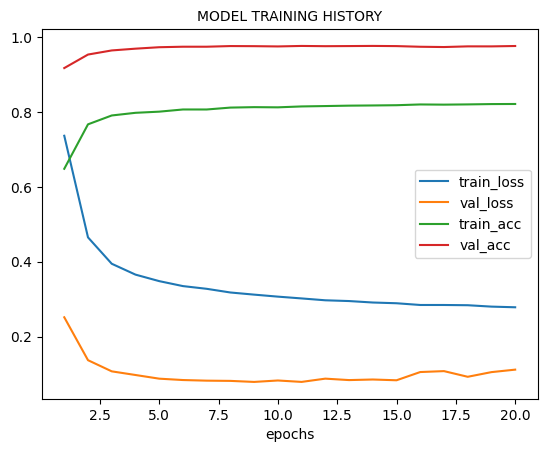

In [59]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, val_losses, label="val_loss")

plt.plot(epochs, train_accuracies, label="train_acc")
plt.plot(epochs, val_accuracies, label="val_acc")

plt.title("MODEL TRAINING HISTORY", color="k", fontsize=10)
plt.legend()
plt.xlabel("epochs", fontsize=10)
plt.show()

### Model Inference

In this section we are going to make predictions using our model. During model inference we are going to do the same feature processing as we did during model training. These feature processing will include something like:

The following functions was used during text cleaning from the previous notebook, so we are redefining them in this notebook so that we can reuse them again.

> We are assuming that the tweet that will be passed by the user during model inference will have `hashtags`, `numbers` and all that so that's why we need this `clean_sentence` function.

In [60]:
def clean_sentence(sent:str)->str:
    """
    Args:
        sent (str): an uncleaned sentence with text, punctuations, numbers 
    """
    sent = sent.lower() # converting the text to lower case
    sent = re.sub(r'(@|#)([A-Za-z0-9]+)', ' ', sent) # removing tags and mentions (there's no right way of doing it with regular expression but this will try)
    sent = re.sub(r"([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+", " ", sent) # removing emails
    sent = re.sub(r'https?\S+', ' ', sent, flags=re.MULTILINE) # removing url's
    sent = re.sub(r'\d', ' ', sent) # removing none word characters
    sent = re.sub(r'[^\w\s\']', ' ', sent) # removing punctuations except for "'" in words like I'm
    sent = re.sub(r'\s+', ' ', sent).strip() # remove more than one space
    words = list()
    for word in sent.split(' '):
        if len(word) == 1 and word not in ['a',  'i']:
          continue
        else:
          words.append(de_contract(word)) # replace word's like "i'm -> i am"
    return " ".join(words)

We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [61]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  text = clean_sentence(text)
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

Let's create our types `Label` and `Prediction`

In [62]:
class Label:
  def __init__(self, label: str, labelId: int, confidence: float):
    self.label = label
    self.labelId = labelId
    self.confidence = confidence

  def __repr__(self) -> str:
    return f"[CBTSA Prediction: {self.label}]"

  def __str__(self) -> str:
    return f"[CBTSA Prediction: {self.label}]"

  def to_json(self):
    return {
        'label':  self.label,
        'labelId':  self.labelId,
        'confidence':  self.confidence,
    }

class Prediction:
  def __init__(self, text: str, label: Label):
    self.text = text
    self.label = label

  def __repr__(self) -> str:
    return f"[CBTSA Preciction: {self.label.label}]"

  def __str__(self) -> str:
    return f"[CBTSA Preciction: {self.label.label}]"

  def to_json(self):
    return {
        'text':  self.text,
        'label':  self.label.to_json(),
    }

Next we are going to create a `predict_sentiment` function which accepts the following:

1. `model` - the model that we have trained
2. `sentence` - which is a tweet text
3. `device` - which is a device that we have defined ealier 

And this function will return a response of type `Prediction` that we have defined ealier in our types.

In [63]:
def predict_sentiment(model, sentence, device): 
  model.eval()
  with torch.no_grad():
    tensor = inference_preprocess_text(sentence.lower()).to(device)
    length = torch.tensor([len(t) for t in tensor])
    out = model(tensor, length)
    out = torch.softmax(out.squeeze(0), dim=0)
    prediction = torch.argmax(out)
    prediction= prediction.detach().cpu().item()
    labels_ = {v:k for k, v in labels_dict.items()}
    label = labels_[prediction]
    _label = Label(label, int(prediction), float(round(out[prediction].item(), 2)))
    return Prediction(
        sentence.lower(), _label
    )

### Nuetral Prediction

In [64]:
predict_sentiment(cbtsa_model, 'i want to place one order delivery courier shipment to me but status mark day please help me courier service no courier head is talking to me and no', device)

[CBTSA Preciction: neutral]

### Negative Prediction

In [65]:
predict_sentiment(cbtsa_model, 'your delivery service is ducking and unreliable rod the worst reputation', device)

[CBTSA Preciction: negative]

### Positive Prediction

In [66]:
predict_sentiment(cbtsa_model, 'exclusive gift pack make your one feel difference to order this high quality gift pack please visit the following link cash on delivery service is available all over the country', device)

[CBTSA Preciction: positive]

### User Input

We can allow users to give us the text and then make predictions on their text. In the following code cell we are going to allow users to give us their input and make predictions based on their input text.


In [67]:
while True:
  text = input("Enter a tweet review (q) to quit:\n")
  if text.lower() == "q":
    break
  prediction = predict_sentiment(cbtsa_model, text, device)

  print()
  print("text: ", prediction.text)
  print("label: ", prediction.label.labelId)
  print("class label: ", prediction.label.label)
  print("probability: ", prediction.label.confidence)
  print()
  print("*" * 90)
  print()


Enter a tweet review (q) to quit:
you are a bad boy i hate you

text:  you are a bad boy i hate you
label:  1
class label:  negative
probability:  1.0

******************************************************************************************

Enter a tweet review (q) to quit:
q


### Model Evaluation metrics
In this section we are going to `evaluate` the best model and `visualize` the metrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.

First of all we need to get the actual labels/sentiments and predicted labels from the `test_iterator` so that we will be able to use all the examples in the test dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `iterator` and `device` as parameter and return the following lists of values:

1. texts - the text or tweet text
2. labels - the actual tweet sentiment label
3. probs - the list of probabilities for the text to belong to a certain sentiment class.

In [68]:
def get_predictions(model, iterator, device):
  model.eval()
  tweets = []
  labels = []
  probs = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      length = torch.tensor([len(t) for t in X])
      y_pred = torch.softmax(model(X, length).squeeze(1), dim=-1)
      prediction = torch.argmax(y_pred)
      # print(prediction)
      top_pred = y_pred.argmax(1, keepdim = True)
      # print(X)
      Xs = [x for x in X]
      texts = [tokens_to_sequence([j.item() for j in i]) for i in Xs]
      tweets.extend([" ".join(i).replace('-pad-', '') for i in texts])
      labels.append(y.cpu())
      probs.append(y_pred.cpu())

  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return tweets, labels, probs

Let's go ahead and get the `tweets`, `labels` and `probabilities` from the `test_iterator` using our `get_predictions` function

In [69]:
test_tweets, test_labels, probs = get_predictions(cbtsa_model, test_loader, device)

assert len(test_tweets) == len(test_labels) == len(probs), f"tweets, labels and probs  must have equal length."

In [70]:
probs[0]

tensor([0.0726, 0.1232, 0.8041])

The probs are not the `predicted` labels, it is a torch tensor of size `3` that looks as follow:

````
tensor([0.8013, 0.1063, 0.0924])`
````
So these are just probabilities that are telling us that, the predicted tweet has `~80%` chance of belonging to class `0`, `~11%` chance of belonging to class `1` and `9%` chance of belonging to class `2`. Basically the model is telling us that, I think the tweet you gave me belongs to sentiment of class `0`.

To get the predicted values from the `tweets` in the `test_set` we need to use the `torch.argmax()` function which returns us the index with the highest number in a torch tensor. We are going to calculate the `argmax` of our probability in the first dimenion to get all the predicted values labels as follows:

In [71]:
pred_labels = torch.argmax(probs, 1)
pred_labels

tensor([2, 1, 0,  ..., 0, 1, 0])

### The confusion matrix
Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting `tweets` in the test dataset. We are going to use a function called `plot_confusion_matrix` from `helperfns` in the following code cell, this function will take in the `real-labels`, predicted labels together with the classes (textual labels e.g, negative, positive or neutral)

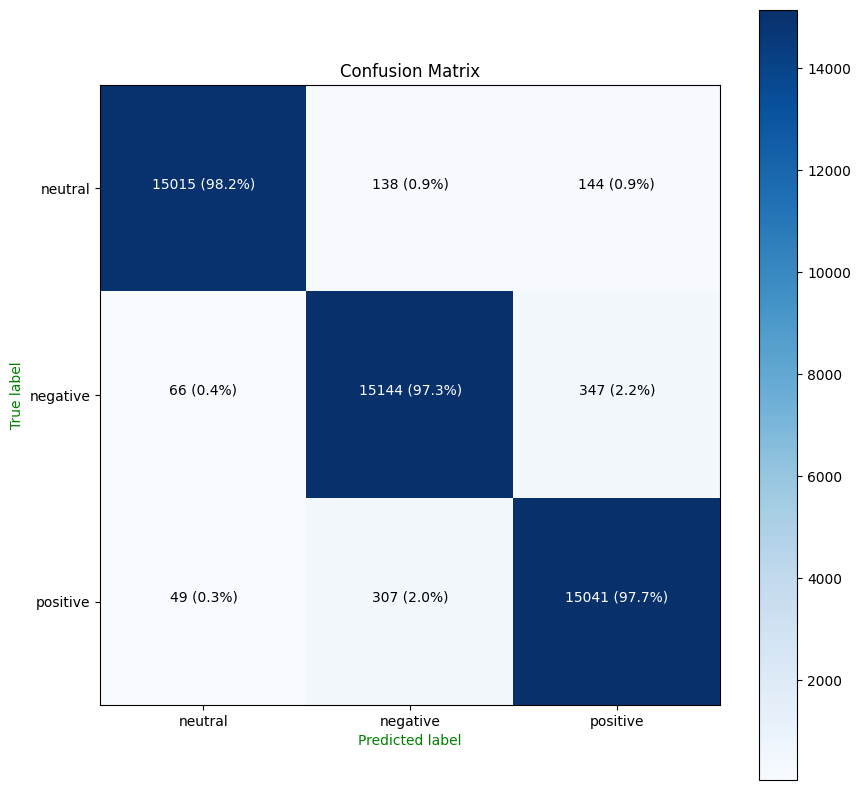

In [72]:
plot_complicated_confusion_matrix(test_labels, pred_labels, sentiments, figsize=(10, 10), fontsize=10)

### Classification report
In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting (positive, negative and neutral) sentiments from tweets.

In [73]:
test_labels[:2]

tensor([2, 1])

In [74]:
cr = classification_report(test_labels, pred_labels, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     15297
           1       0.97      0.97      0.97     15557
           2       0.97      0.98      0.97     15397

    accuracy                           0.98     46251
   macro avg       0.98      0.98      0.98     46251
weighted avg       0.98      0.98      0.98     46251



### Downloading the Model

To download the model from google colab we do it as follows:


In [75]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Additional Resources

1. [paperswithcode.com](https://paperswithcode.com/task/sentiment-analysis)